# ***TASK 2***

Description:

"The file “Parts.csv” contains descriptions of some fictitious parts. Your goal is to find 5 alternative parts to each provided fictitious part in the dataset based on their similarity. First provide descriptive analysis of the data and highlight 2-3 findings and difficulties of the data that we provided and describe how you would handle this. Continue to implement a model that is finding the similar fictitious parts based on the column “DESCRIPTION”. Please give details of your model and why you choose this. Once you finished your implementation of your chosen model, please think about how you would change or addition your code, when you have more entries and would consider the additional attributes."


### My interpretation of this question

Based on my reading of Task 2, **I interpret this to mean that we should *only* use the column `DESCRIPTION` for both the outlier detection model *and* the dimensionality reduction model**. Generally, you would want to use multiple features to identify outliers; however, without knowing how the data for these fictitious parts were generated (i.e. perhaps including other features in one or both models would add statistical noise, degrading model performance), I exclude them from this task.

In [1]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', None)

## Read data

In [2]:
df = pd.read_csv('./data/parts.csv', sep=';')
print(df.shape)
df.head()

(998, 32)


,ID,DESCRIPTION,Attribut1,Additional Feature,Application,Characteristic,Temp,Height,Length in mm,Rating,Material,Size,Code,Joule-integral-Nom (J),LC Risk,Maximum AC Voltage Rating,Maximum DC Voltage Rating,Maximum Power Dissipation,Mounting,Mounting Feature,Number of Terminals,Operating Temperature-Max (Cel),Operating Temperature-Min (Cel),Physical Dimension,Pre-arcing time-Min (ms),Product Diameter,Product Length,Rated Breaking Capacity (A),Rated Current (A),Rated Voltage (V),Rated Voltage(AC) (V),Rated Voltage(DC) (V)
0,A1,"Indicator Red Fast Movement 1.6A 250V Holder Plastic 5 X 20mm Ceramic Box CCC/PSE/VDE/cULus Electric Indicator, Very Fast Blow, 1.6A, 250VAC, 1500A (IR), Inline/holder, 5x20mm",Fast,NaN,Primary Protection In Equipment,VERY FAST,NaN,20mm,5.2mm,1.6A,Ceramic,5 X 20mm,NaN,0.755J,Low,250V,NaN,4W,Holder,INLINE/HOLDER,2.0,125Cel,-55Cel,5.2mm x 20mm,3ms,5.2mm,20mm,1500A,1.6A,250V,250V,NaN
1,A2,"Non Resettable Indicators Electric Indicator, Very Fast Blow, 6.3A, 250VAC, 1500A (IR), Inline/holder, 5x20mm",NaN,NaN,Primary Protection In Equipment,VERY FAST,NaN,20mm,5.2mm,NaN,Ceramic,5 X 20mm,e2,36.7J,Low,NaN,NaN,NaN,Holder,INLINE/HOLDER,2.0,125Cel,-55Cel,5.2mm x 20mm,3ms,5.2mm,20mm,1500A,6.3A,250V,250V,NaN
2,A3,"Indicator Red Fast Movement 8A 250V Holder Plastic 5 X 20mm Ceramic Box KC/PSE/VDE/cULus Electric Indicator, Very Fast Blow, 8A, 250VAC, 1500A (IR), Inline/holder, 5x20mm",Fast,NaN,Primary Protection In Equipment,VERY FAST,NaN,20mm,5.2mm,8A,Ceramic,5 X 20mm,e2,81.9J,Low,250V,NaN,4W,Holder,INLINE/HOLDER,2.0,125Cel,-55Cel,5.2mm x 20mm,10ms,5.2mm,20mm,1500A,8A,250V,250V,NaN
3,A4,"Non Resettable Indicators Electric Indicator, Very Fast Blow, 10A, 250VAC, 1500A (IR), Inline/holder, 5x20mm",NaN,NaN,Primary Protection In Equipment,VERY FAST,NaN,20mm,5.2mm,NaN,Ceramic,5 X 20mm,e2,141J,Low,NaN,NaN,NaN,Holder,INLINE/HOLDER,2.0,125Cel,-55Cel,5.2mm x 20mm,10ms,5.2mm,20mm,1500A,10A,250V,250V,NaN
4,A5,"Indicator Red Fast Movement 12.5A 250V Holder Plastic 5 X 20mm Ceramic Box PSE/cULus Electric Indicator, Very Fast Blow, 12.5A, 250VAC, 500A (IR), Inline/holder, 5x20mm",Fast,NaN,Primary Protection In Equipment,VERY FAST,NaN,20mm,5.2mm,12.5A,Ceramic,5 X 20mm,NaN,203J,Low,250V,NaN,6.9(Typ)W,Holder,INLINE/HOLDER,2.0,125Cel,-55Cel,5.2mm x 20mm,10ms,5.2mm,20mm,500A,12.5A,250V,250V,NaN


## Preprocess & EDA

In this section I provide a description analysis of the column `DESCRIPTION` and proceed with preprocessing this field for downstream modeling. I also point out assumptions I make about the data generating process and challenges with using these data for this particular task.

### Missing values in `DESCRIPTION`

To begin, **I assume missingness in this feature is uncorrelated with being an outlier (i.e. a fictitious part); thus I drop all rows with missing data**

In [3]:
df['DESCRIPTION'].isnull().mean()

0.33567134268537074

In [4]:
df = df[df['DESCRIPTION'].notnull()].reset_index(drop=True)
print(df.shape)

(663, 32)


### Duplicates in `DESCRIPTION`

After the above step, we find 81 duplicates in the data (see examples below). **I drop these duplicate observations, assuming that data duplication is unrelated to being an outlier** (i.e. a fictitious part). This simplifies downstream identification of outliers and more importantly identification of related parts.

In [5]:
df['DESCRIPTION'].duplicated().sum()

81

In [6]:
dup = df['DESCRIPTION'].duplicated(keep=False)

In [7]:
df[dup][['DESCRIPTION']].sort_values(by=['DESCRIPTION']).head(10)

,DESCRIPTION
659,"Indicator Chip Slow Blow Movement 1.5A 125V SMD Solder Pad 2410 Ceramic T/R CSA/PSE/UL Electric Indicator, Slow Blow, 1.5A, 125VAC, 125VDC, 50A (IR), Surface Mount, NANO"
657,"Indicator Chip Slow Blow Movement 1.5A 125V SMD Solder Pad 2410 Ceramic T/R CSA/PSE/UL Electric Indicator, Slow Blow, 1.5A, 125VAC, 125VDC, 50A (IR), Surface Mount, NANO"
633,"Indicator Chip Slow Blow Movement 1A 125V SMD Solder Pad 2410 Ceramic T/R CSA/PSE/UL Electric Indicator, Slow Blow, 1A, 125VAC, 125VDC, 50A (IR), Surface Mount, NANO"
635,"Indicator Chip Slow Blow Movement 1A 125V SMD Solder Pad 2410 Ceramic T/R CSA/PSE/UL Electric Indicator, Slow Blow, 1A, 125VAC, 125VDC, 50A (IR), Surface Mount, NANO"
662,"Indicator Chip Slow Blow Movement 2.5A 125V SMD Solder Pad 2410 Ceramic T/R CSA/PSE/UL Electric Indicator, Slow Blow, 2.5A, 125VAC, 125VDC, 50A (IR), Surface Mount"
661,"Indicator Chip Slow Blow Movement 2.5A 125V SMD Solder Pad 2410 Ceramic T/R CSA/PSE/UL Electric Indicator, Slow Blow, 2.5A, 125VAC, 125VDC, 50A (IR), Surface Mount"
637,"Indicator Chip Slow Blow Movement 2A 125V SMD Solder Pad 2410 Ceramic T/R CSA/PSE/UL Electric Indicator, Slow Blow, 2A, 125VAC, 125VDC, 50A (IR), Surface Mount, NANO"
639,"Indicator Chip Slow Blow Movement 2A 125V SMD Solder Pad 2410 Ceramic T/R CSA/PSE/UL Electric Indicator, Slow Blow, 2A, 125VAC, 125VDC, 50A (IR), Surface Mount, NANO"
642,"Indicator Chip Slow Blow Movement 3A 125V SMD Solder Pad 2410 Ceramic T/R CSA/PSE/UL Electric Indicator, Slow Blow, 3A, 125VAC, 125VDC, 50A (IR), Surface Mount, NANO"
643,"Indicator Chip Slow Blow Movement 3A 125V SMD Solder Pad 2410 Ceramic T/R CSA/PSE/UL Electric Indicator, Slow Blow, 3A, 125VAC, 125VDC, 50A (IR), Surface Mount, NANO"


In [8]:
df = df[~df['DESCRIPTION'].duplicated()].reset_index(drop=True)
assert df['DESCRIPTION'].duplicated().sum() == 0

### Variation in description length (according to characters)

Stripping whitespace (but leaving punctuation) from `DESCRIPTION`, we see considerable variation in length according to the number of characters. This ranges from 39 to 179 total characters. **While this suggests the length of descriptions vary, we do not a-priori know whether this relates to being an outlier.**

In [9]:
char = df['DESCRIPTION'].apply(lambda x: len(list(x.replace(' ', ''))))

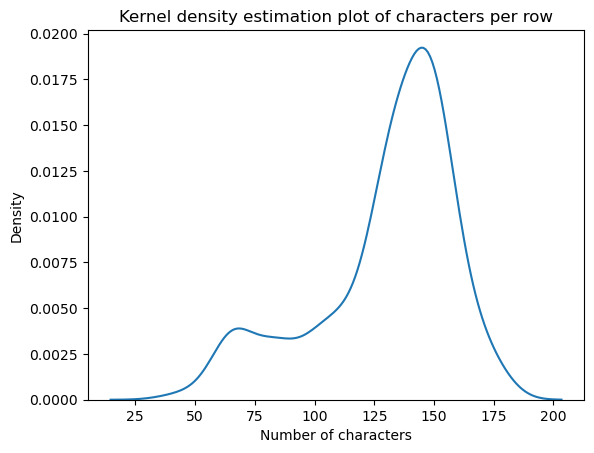

In [10]:
sns.kdeplot(char)
plt.xlabel("Number of characters")
plt.title("Kernel density estimation plot of characters per row")
plt.show()

In [11]:
char.describe()

count    582.000000
mean     129.867698
std       29.000291
min       39.000000
25%      118.250000
50%      137.500000
75%      150.000000
max      179.000000
Name: DESCRIPTION, dtype: float64

### Identifying distinct words & concepts in `DESCRIPTION`

**Identifying distinct word and concepts in these data is especially challenging since the data contain numerous (technical) acronyms, abbreviations, and mathematical measurements (e.g. part length)**

Ideally, we would be provided with information about how the field `DESCRIPTION` is generated, which would allow for better identification of distinct words and concepts. Barring this information - and in the interest of time -, I use a standard text preprocessor, sklearn's `TfidfVectorizer`, and proceed with modeling below. Importantly, however, this reliance on a standard preprocessor will not deliver as good of performance as we would otherwise expect with better engineered (i.e. more manual, with knowledge about the data) preprocessing.

In [12]:
df[['DESCRIPTION']].head()

,DESCRIPTION
0,"Indicator Red Fast Movement 1.6A 250V Holder Plastic 5 X 20mm Ceramic Box CCC/PSE/VDE/cULus Electric Indicator, Very Fast Blow, 1.6A, 250VAC, 1500A (IR), Inline/holder, 5x20mm"
1,"Non Resettable Indicators Electric Indicator, Very Fast Blow, 6.3A, 250VAC, 1500A (IR), Inline/holder, 5x20mm"
2,"Indicator Red Fast Movement 8A 250V Holder Plastic 5 X 20mm Ceramic Box KC/PSE/VDE/cULus Electric Indicator, Very Fast Blow, 8A, 250VAC, 1500A (IR), Inline/holder, 5x20mm"
3,"Non Resettable Indicators Electric Indicator, Very Fast Blow, 10A, 250VAC, 1500A (IR), Inline/holder, 5x20mm"
4,"Indicator Red Fast Movement 12.5A 250V Holder Plastic 5 X 20mm Ceramic Box PSE/cULus Electric Indicator, Very Fast Blow, 12.5A, 250VAC, 500A (IR), Inline/holder, 5x20mm"


### TF-IDF vectorizer of words in `DESCRIPTION`

`TfidfVectorizer` converts a collection of raw documents to a matrix of TF-IDF features. [Term frequency-inverse document frequency (TF-IDF)](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) is a statistic that reflects how important a word is in a document relative to a collection of documents (a corpus). TF-IDF is a [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) approach, where documents are described by word occurrences, while ignoring the relative position of words in a document.

Specifically `TfidfVectorizer`:
- Tokenizes words (i.e. removes whitespace, punctuation, lower cases words, removes stop words)
- Counts the occurrences of tokens in each document
- Normalizes and weights tokens according to their importance


In [13]:
tfidf = TfidfVectorizer(ngram_range=(1, 1))
X_tfidf = tfidf.fit_transform(df['DESCRIPTION'])
print(X_tfidf.shape)

(582, 211)


## Modeling outliers

***The primary difficulty of working with these data is that we are provided no information about how to identify outliers / fictitious parts.*** Specifically,

1. There is no outlier label (i.e. this is an unsupervised task)
2. We lack information about what outliers might actually look like
3. We lack information about the expected share of outliers in the data

Unsupervised outlier detection models typically require that the user have some a-priori knowledge about what outliers look like or at least roughly the share of outliers in the data. Since we have neither in this case, I assume the observations identified as most likely outliers

### Isolation Forest

In [14]:
isof = IsolationForest(random_state=123, contamination='auto')
isof.fit(X_tfidf)
isof_score = pd.Series(isof.decision_function(X_tfidf)).rename('isof_score')

In [15]:
isof_score.describe()

count    582.000000
mean       0.126438
std        0.016562
min        0.048103
25%        0.117937
50%        0.129318
75%        0.137934
max        0.156464
Name: isof_score, dtype: float64

In [16]:
concatenated = pd.concat([df['DESCRIPTION'], isof_score], axis=1)

In [17]:
concatenated.sort_values(by=['isof_score']).head(10)

,DESCRIPTION,isof_score
274,"Indicator Blade 1A 32V Socket 19.1 X 12.3 X 5.1mm Polyamide 66 Automotive UL Electric Indicator, 1A, 32VDC, 1000A (IR), ATOF, Inline/holder",0.048103
277,"Indicator Blade 4A 32V Socket 19.1 X 12.3 X 5.1mm Polyamide 66 Automotive UL Electric Indicator, 4A, 32VDC, 1000A (IR), ATOF, Inline/holder",0.051854
278,"Indicator Blade 10A 32V Socket 19.1 X 12.3 X 5.1mm Polyamide 66 Automotive UL Electric Indicator, 10A, 32VDC, 1000A (IR), ATOF, Inline/holder",0.053069
276,"Indicator Blade 3A 32V Socket 19.1 X 12.3 X 5.1mm Polyamide 66 Automotive UL Electric Indicator, 3A, 32VDC, 1000A (IR), Inline/holder",0.064113
275,"Indicator Blade 2A 32V Socket 19.1 X 12.3 X 5.1mm Polyamide 66 Automotive UL Electric Indicator, 2A, 32VDC, 1000A (IR), Inline/holder",0.065218
269,"Indicator SubRed Very Fast Movement 1.5A 125V Radial 6 X 8mm Bulk CSA Electric Indicator, Very Fast Blow, 1.5A, 125VAC, 125VDC, 10000A (IR), Through Hole, MICRO",0.070769
272,"Indicator SubRed Very Fast Movement 0.5A 125V Radial 6 X 8mm Bulk CSA Electric Indicator, Very Fast Blow, 0.5A, 125VAC, 125VDC, 10000A (IR), Through Hole, MICRO",0.070769
266,"Indicator SubRed Very Fast Movement 0.125A 125V Axial 2.8 X 7.11mm Epoxy Coated CCC/CSA/PSE/QPL/TUV/UL Electric Indicator, Very Fast Blow, 0.125A, 125VAC, 125VDC, 50A (IR), Supplemental, Through Hole, PICO",0.072034
263,"Indicator SubRed Very Fast Movement 10A 125V Axial 2.8 X 7.11mm Ceramic T/R CSA/TUV/UL Electric Indicator, Very Fast Blow, 10A, 125VAC, 125VDC, 50A (IR), Supplemental, Through Hole, PICO",0.077196
270,"Indicator SubRed Very Fast Movement 0.05A 125V Radial 6 X 8mm Bulk CSA Electric Indicator, Very Fast Blow, 0.05A, 125VAC, 125VDC, 10000A (IR), Through Hole, MICRO",0.077671


### One class SVM

In [18]:
oc_svm = OneClassSVM()
oc_svm.fit(X_tfidf)
oc_svm_score = pd.Series(oc_svm.decision_function(X_tfidf)).rename('oc_svm_score')

In [19]:
oc_svm_score.describe()

count    582.000000
mean      -0.949465
std        3.692749
min      -15.483555
25%       -2.373773
50%       -0.000014
75%        1.328242
max        5.121953
Name: oc_svm_score, dtype: float64

In [20]:
concatenated = pd.concat([concatenated, oc_svm_score], axis=1)

In [21]:
concatenated.sort_values(by=['oc_svm_score']).head(50)

,DESCRIPTION,isof_score,oc_svm_score
282,Intrinsically Safe Indicator Electric Indicator,0.138855,-15.483555
96,"Indicator Misc, Non resettable Indicators, Red Indicators, Typ FTT 5x20 Indicator",0.116227,-14.657814
65,Indicator Holder Surface Mount Tapend Reel Indicators/Accessories,0.123565,-14.443737
273,"Thru-Hole Circuit Board Mount Radial Leaded Indicator Holders Indicator ACCESSORY, Indicator HOLDER",0.091335,-13.917851
81,"Red Indicator, 5 X 20 mm, Time-Lag T, L, 250 VAC Electric Indicator",0.132994,-12.888482
63,Indicator Holder 10A 250VAC Panel Mount Quick Connect Box Indicators/Accessories,0.104457,-12.833196
95,Indicator 0.063A 250V Super Time Lag Movement Indicator,0.125702,-12.650297
56,Indicator Holder 16A 250VAC Solder Lug Through Hole Box ROTARY SWITCH-,0.134978,-12.433100
104,"Indicator Clip 10A Panel Mount Pin Indicator ACCESSORY, Indicator CLIP",0.122410,-11.959686
279,"Indicator Blade 20A 32V Socket 19.1 X 5.1 12.3mm Nylon Automotive Electric Indicator, 20A, 32VDC, 1000A (IR), Inline/holder",0.079509,-11.873466
